# Intellligent Data Analysis

- **Data Set:** #31
- **Author 1:** Juraj Baráth
- **Author 2:** Vladimír Svitok

## Strojové učenie (max. 15b)

Pri dátovej analýze nemusí byť naším cieľom získať len znalosti obsiahnuté v aktuálnych dátach, ale aj natrénovať model, ktorý bude schopný robiť rozumné predikcie pre nové pozorovania. Na to sa využívajú techniky strojového učenia. V tomto projekte sa zameriame na rozhodovacie stromy vzhľadom na ich jednoduchú interpretovateľnosť.

V tejto fáze dostanete nový dataset, na ktorom oddemonštrujete znovupoužiteľnosť vami realizovaného predspracovania. Vami natrénované klasifikátory budú porovnané medzi sebou; uvidíte tak, ako dobre ste sa umiestnili v rámci vášho cvičenia, resp. celého predmetu.

V poslednej fáze sa od vás očakáva:
- **Predspracovanie nového datasetu vami realizovaným postupom predspracovania a opis prípadných zmien (2b).** Spustite postup predspracovania realizovaný v predchádzajúcej fáze nad novým datasetom. Nový dataset bude mať rovnakú štruktúru ako váš pôvodný, nebudú sa v ňom však možno nachádzať niektoré problémy (nové vám nepribudnú). Ak si spustenie predspracovania vyžiada zmeny v kóde, opíšte ich.
- **Manuálne vytvorenie a vyhodnotenie rozhodovacích pravidiel pre klasifikáciu (3b).** Vyskúšajte jednoduché pravidlá zahŕňajúce jeden atribút, ale aj komplikovanejšie zahŕňajúce viacero atribútov (ich kombinácie). Pravidlá by v tomto kroku mali byť vytvorené manuálne na základe pozorovaných závislostí v dátach. Pravidlá (manuálne vytvorené klasifikátory) vyhodnoťte pomocou metrík správnosť (angl. *accuracy*), presnosť (angl. *precision*) a úplnosť (angl. *recall*). 
- **Natrénovanie a vyhodnotenie klasifikátora s využitím rozhodovacích stromov (4b).** Na trénovanie využite algoritmus dostupný v knižnici `scikit-learn` (`CART`). Vizualizujte natrénované pravidlá. Vyhodnoťte natrénovaný rozhodovací strom pomocou metrík správnosť (angl. *accuracy*), presnosť (angl. *precision*) a úplnosť (angl. *recall*). Porovnajte natrénovaný klasifikátor s vašimi manuálne vytvorenými pravidlami z druhého kroku. 
- **Optimalizácia hyperparametrov (4b).** Preskúmajte hyperparametre klasifikačného algoritmu `CART` a vyskúšajte ich rôzne nastavenie tak, aby ste minimalizovali preučenie. Vysvetlite, čo jednotlivé hyperparametre robia. Pri nastavovaní hyperparametrov algoritmu využite 10-násobnú krížovú validáciu na trénovacej množine.
- **Vyhodnotenie vplyvu zvolenej stratégie riešenia chýbajúcich hodnôt na správnosť klasifikácie (2b).** Zistite, či použitie zvolených stratégií riešenia chýbajúcich hodnôt vplýva na správnosť (angl. accuracy) klasifikácie. Ktorá stratégia sa ukázala ako vhodnejšia pre daný problém?

Správa sa odovzdáva v 12. týždni semestra na cvičení (dvojica svojmu cvičiacemu odprezentuje výsledky strojového učenia v `Jupyter Notebooku`). Následne správu elektronicky odovzdá jeden člen z  dvojice do systému AIS do **nedele 15.12.2019 do 23:59**.


In [1]:
# Automatically reformat python code
# Check https://medium.com/openplanetary/code-formatting-in-jupyter-cells-8fee4eda072f for more info
# %load_ext lab_black

# Data analysis and debugging helper methods

In [2]:
"""
    Checks the not availability of a value
"""


def is_nan(v):
    sv = str(v)
    return sv == "?" or sv == "NaN" or sv == "nan"

In [3]:
"""
    Prints the possible values of columns having less than 50 possible values
    For columns having numeric values prints the min, 5% percentile, 95% percentile, max, mean, median
"""


def print_col_values(d):

    """ Formats a number by converting floats to 4 decimals and keeps integers"""

    def format_num(num):
        num = round(num, 4)
        return int(num) if num == int(num) else num

    cols = list(d.columns)
    cols.sort()

    for c in cols:
        if str(d.iloc[0][c]).replace(".", "").isdigit():
            v = d[c].apply(
                lambda n: float(n) if str(n).replace(".", "").isdigit() else np.nan
            )
            print(
                "••► " + c + ": min = {}, 5% = {}, 95% = {}, max = {},"
                " mean = {}, median = {}".format(
                    format_num(v.min()),
                    format_num(np.nanpercentile(v, 5)),
                    format_num(np.nanpercentile(v, 95)),
                    format_num(v.max()),
                    format_num(v.mean()),
                    format_num(v.median()),
                ),
                end="\n\n",
            )
        else:
            l = list(d.drop_duplicates(c)[c])
            if len(l) < 50:
                print("••► " + c + " (" + str(len(l)) + "): " + str(l), end="\n\n")
            else:
                print("••► " + c + " (" + str(len(l)) + ")", end="\n\n")

In [4]:
"""
    Prints the statistics of both personal and other train data at a certain stage
"""


def print_data_stats(stage, data, data2):
    print(
        "=========================="
        + stage
        + " ======================"
    )
    print("===== Data =====")
    print_col_values(data)
    print("==== Data 2 =====")
    print_col_values(data2)

In [5]:
"""
    Draws a chart of a column in the data set with the given label
"""


def draw_chart(label, data, column):
    data.plot.scatter(label=label, x="id", y=column, figsize=(15, 5)).plot()

In [6]:
"""
    Draws charts of the medical metrics data against the class with the given titles in the given data sets
"""


def draw_md_charts(titles, data_array):
    for gl in [
        "skewness_glucose",
        "mean_glucose",
        "kurtosis_glucose",
        "std_glucose",
        "mean_oxygen",
        "std_oxygen",
        "kurtosis_oxygen",
        "skewness_oxygen",
    ]:
        for cl in range(2):
            for i in range(len(data_array)):
                d_source = data_array[i]
                d = d_source[d_source["class"] == cl]
                draw_chart(titles[i] + " - " + gl + " - Class " + str(cl), d, gl)

# Data transformations

In [7]:
"""
    Renames the Unnamed: 0 column to id
"""


def rename_id_column(data, data2, debug):
    data.rename(columns={data.columns[0]: "id"}, inplace=True)
    data2.rename(columns={data2.columns[0]: "id"}, inplace=True)
    return data, data2

In [8]:
""" 
    Extracts the 4 columns of the medical info from data2 and puts them as new columns, removes the old column
"""


def extract_medical_info(data, data2, debug):
    # Generate the list of columns we need to extract from medical_info
    mi_cols = list(dict(eval(data2["medical_info"][0])).keys())
    # Extract the 4 data included in the medical_info column and put it to 4 separate columns
    for c in mi_cols:
        data2[c] = data2["medical_info"].apply(
            lambda d: 0.0 if str(d) == "nan" else float(dict(eval(str(d)))[c])
        )
    data2.drop(columns="medical_info", inplace=True)
    return data, data2

In [9]:
""" 
    Removes the time from the date_of_birth and replaces "/" characters to "-" characters in it
"""


def fix_date_of_birth(data, data2, debug):
    # Remove time from the date_of_birth
    data["date_of_birth"] = data["date_of_birth"].str.split(" ", expand=True)[0]

    # Replace '/' characters to '-' characters in date_of_birth
    data["date_of_birth"] = data["date_of_birth"].str.replace("/", "-")
    return data, data2

In [10]:
"""
    Replace non numeric age values with 0
"""


def fix_non_numeric_age_values(data, data2, debug):
    data["age"] = data["age"].apply(
        lambda age: int(age) if str(age).replace(".", "", 1).isdigit() else 0
    )
    return data, data2

In [11]:
"""
    Fix the date format in the date_of_birth, make it consistently being yyyy-mm-dd
"""


def fix_date_format(data, data2, debug):
    def fix_date(date):
        s = date.split("-")
        if (
            len(s[0]) == 4
        ):  # Don't need to fix anything if the first field is a 4 digit year number
            return date
        if len(s[2]) == 4:  # Replace dd-mm-yyyy format to yyyy-mm-dd format
            return s[2] + "-" + s[1] + "-" + s[0]

        # Replace yy-mm-dd format to yyyy-mm-dd format
        #
        # If the last 2 digit of the 4 digit year field is bigger than 20,
        # then we expect a date of birth between 1921 and 1999, otherwise between 2000 and 2020,
        # because we have verified earlier that we don't have people older than 90 years old in such date format
        if int(s[0]) > 20:
            return "19" + s[0] + "-" + s[1] + "-" + s[2]
        else:
            return "20" + s[0] + "-" + s[1] + "-" + s[2]

        return date

    data["date_of_birth"] = data["date_of_birth"].apply(fix_date)
    return data, data2

In [12]:
"""
    Calculate the missing ages of people based on the dataset date
"""


def calc_missing_ages_from_date_of_birth(data, data2, debug):
    # Approximate the date of the dataset by adding the age of people to their date_of_birth. Choose the highest value.
    def add_age(row):
        return (
            str(int(row["date_of_birth"][:4]) + row["age"]) + row["date_of_birth"][4:]
        )

    # Fixes the age based on the previously calculated dataset age
    def fix_age(row):
        if row["age"] == 0:
            birth = [int(i) for i in row["date_of_birth"].split("-")]
            dif = [ds_date[0] - birth[0], ds_date[1] - birth[1], ds_date[2] - birth[2]]
            if debug:
                print(ds_date, "-", birth, "=", dif, end=" --> age = ")
            if dif[2] < 0:
                dif[1] -= 1
            if dif[1] < 0:
                dif[0] -= 1
            if debug:
                print(dif[0])
            return dif[0]
        return row["age"]

    ds_date = [int(i) for i in data.apply(add_age, axis=1).max().split("-")]
    if debug:
        print("Data set age:", ds_date)

    data["age"] = data.apply(lambda row: fix_age(row), axis=1)
    return data, data2

In [13]:
"""
    Trim all the leading spaces from every String data
"""


def trim_leading_spaces(data, data2, debug):
    for d in (data, data2):
        for c in d.columns:
            d[c] = d[c].apply(lambda s: s if type(s) != str else s.strip())
    return data, data2

In [14]:
"""
    Merge duplicate rows by choosing the average of every available data,
    for non numeric data using the first available match.

    If one of the numeric value is 0, while a none zero value exist, ignore the zero value
"""


def merge_duplicate_rows(data, data2, debug):
    if debug:
        print("Detecting duplicates based on names...")

    duplicate_names = list(data2[data2.duplicated(["name"])]["name"])
    if debug:
        print("Found", len(duplicate_names), "duplicates, merging them...")

    fixed_rows = []

    for name in duplicate_names:
        rows = data2[data2["name"] == name]
        l = len(rows)
        if debug:
            print("\nMerging", l, "rows of name " + name + "...")
        bestRow = rows.iloc[0].copy()
        for c in data2.columns:
            if c == "id":  # Do not merge the id column
                continue
            if debug:
                print(c, list(rows[c]), end=" --> ")
            m = 1
            for i in range(1, l):
                row = rows.iloc[i]
                if is_nan(row[c]):
                    continue
                if is_nan(bestRow[c]):
                    bestRow[c] = row[c]
                    m = 1
                elif (type(row[c]) != str) and row[c] != 0 and row[c] != 0.0:
                    bestRow[c] += row[c]
                    if bestRow[c] != row[c]:
                        m += 1
            if type(bestRow[c]) != str and m > 0:
                bestRow[c] /= m
            if debug:
                print([bestRow[c]], end="\n")
        fixed_rows.append(bestRow)

    if debug:
        print("Applying changes...")

    data2.drop_duplicates(subset=["name"], keep=False, inplace=True)
    for r in fixed_rows:
        data2 = data2.append(r)
    return data, data2

In [15]:
"""
    Fixes the pregnant column values, keeps nan rows, changes others to 1 
    if they start with t (case insensitive), changes them to 0 otherwise
"""


def fix_pregnant(data, data2, debug):
    data2["pregnant"] = data2["pregnant"].apply(
        lambda p: np.nan if str(p) == "nan" else int(p[0].lower() == "t")
    )
    return data, data2

In [16]:
"""
    Replaces missing data with median values for numbers and
    with the data having the highest occurance at Strings
"""


def replace_missing_data_with_medians(data2, rdata2, debug):
    if debug:
        print("Filling missing data with median values...")
    for c in data2.columns:
        med = (
            data2[c].value_counts().idxmax()
            if type(data2.iloc[0][c]) == str
            else data2[c].median()
        )
        if debug:
            print(c, "-->", med)
        data2[c] = data2[c].apply(lambda v: med if is_nan(v) else v)  
        rdata2[c] = rdata2[c].apply(lambda v: med if is_nan(v) else v)
    return data2, rdata2

In [17]:
"""
    Replaces missing data with linear regression for numbers and
    with the data having the highest occurance at Strings
"""


def replace_missing_data_with_regr(data2, rdata2, debug):
    if debug:
        print("Filling missing data with linear regression values...")
    model1 = LinearRegression()
    model2 = LinearRegression()
    modeldata = data2[data2[['mean_glucose','std_glucose']].notnull().all(axis=1)]
    x = np.array(modeldata['mean_glucose']).reshape(-1,1)
    y = np.array(modeldata['std_glucose']).reshape(-1,1)
    model1.fit(x, y)
    model2.fit(y, x)
    data2['mean_glucose'] = data2.apply(lambda row: (
        row['mean_glucose'] if not is_nan(row['mean_glucose']) else (model2.intercept_ + model2.coef_ * row['std_glucose'])[0][0] if not is_nan(row['std_glucose']) else np.nan
    ), axis=1)
    data2['std_glucose'] = data2.apply(lambda row: (
        row['std_glucose'] if not is_nan(row['std_glucose']) else (model1.intercept_ + model1.coef_ * row['mean_glucose'])[0][0] if not is_nan(row['mean_glucose']) else np.nan
    ), axis=1)
    rdata2['mean_glucose'] = rdata2.apply(lambda row: (
        row['mean_glucose'] if not is_nan(row['mean_glucose']) else (model2.intercept_ + model2.coef_ * row['std_glucose'])[0][0] if not is_nan(row['std_glucose']) else np.nan
    ), axis=1)
    rdata2['std_glucose'] = rdata2.apply(lambda row: (
        row['std_glucose'] if not is_nan(row['std_glucose']) else (model1.intercept_ + model1.coef_ * row['mean_glucose'])[0][0] if not is_nan(row['mean_glucose']) else np.nan
    ), axis=1)
    return data2, rdata2

In [18]:
"""
    Replaces outlying values in every numeric column the following way:
    --> Applies 90% percentil for values >90% percentil * 2 of the data set
    --> Applies 10% percentil for values <10% percentil * 0.5 of the data set
"""


def replace_outlying_0595(data2, rdata2, debug):
    for c in data2.columns:
        if type(data2.iloc[0][c]) == str or len(list(data2.drop_duplicates(c)[c])) <= 10:
            continue
        pct10 = np.nanpercentile(data2[c], 10)
        pct90 = np.nanpercentile(data2[c], 90)
        data2[c] = data2[c].apply(
            lambda d: pct90 if d > pct90 * 2 else pct10 if d < pct10 * 0.5 else d
        )
        rdata2[c] = rdata2[c].apply(
            lambda d: pct90 if d > pct90 * 2 else pct10 if d < pct10 * 0.5 else d
        )

    return data2, rdata2

# Invokers of the data transformations

In [19]:
"""
    Transforms the train data into a usable trainable form
"""


def fix_data(data, data2, rdata, rdata2, debug):

    data, data2 = rename_id_column(data, data2, debug)
    data, data2 = extract_medical_info(data, data2, debug)
    data, data2 = fix_date_of_birth(data, data2, debug)
    data, data2 = fix_non_numeric_age_values(data, data2, debug)
    data, data2 = fix_date_format(data, data2, debug)
    data, data2 = calc_missing_ages_from_date_of_birth(data, data2, debug)
    data, data2 = trim_leading_spaces(data, data2, debug)
    data, data2 = merge_duplicate_rows(data, data2, debug)
    data, data2 = fix_pregnant(data, data2, debug)
    
    rdata, rdata2 = rename_id_column(rdata, rdata2, debug)
    rdata, rdata2 = extract_medical_info(rdata, rdata2, debug)
    rdata, rdata2 = fix_date_of_birth(rdata, rdata2, debug)
    rdata, rdata2 = fix_non_numeric_age_values(rdata, rdata2, debug)
    rdata, rdata2 = fix_date_format(rdata, rdata2, debug)
    rdata, rdata2 = calc_missing_ages_from_date_of_birth(rdata, rdata2, debug)
    rdata, rdata2 = trim_leading_spaces(rdata, rdata2, debug)
    rdata, rdata2 = merge_duplicate_rows(rdata, rdata2, debug)
    rdata, rdata2 = fix_pregnant(rdata, rdata2, debug)
    
    data2, rdata2 = replace_missing_data_with_regr(data2, rdata2, debug)
    data2, rdata2 = replace_missing_data_with_medians(data2, rdata2, debug)
    data2, rdata2 = replace_outlying_0595(data2, rdata2, debug)
    return pd.merge(data, data2, on = 'name'), pd.merge(rdata, rdata2, on = 'name')

# Here starts the actual program

In [20]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
from sklearn.linear_model import LinearRegression
import json
import seaborn as sns

In [21]:
# Read train data
data = pd.read_csv("personal_train.csv")
data2 = pd.read_csv("other_train.csv")
rdata = pd.read_csv("personal_valid.csv")
rdata2 = pd.read_csv("other_valid.csv")

In [22]:
# Print train data before fix
print_data_stats("BEFORE FIX - TRAIN", data, data2)

==========================BEFORE FIX - TRAIN ======================
===== Data =====
••► Unnamed: 0: min = 0, 5% = 196.6, 95% = 3735.4, max = 3932, mean = 1966, median = 1966

••► address (3933)

••► age: min = 3, 5% = 32, 95% = 70, max = 99, mean = 51.8638, median = 52

••► date_of_birth (3706)

••► name (3933)

••► sex (2): [' Male', ' Female']

==== Data 2 =====
••► Unnamed: 0: min = 0, 5% = 199.1, 95% = 3782.9, max = 3982, mean = 1991, median = 1991

••► address (3933)

••► capital-gain: min = 0, 5% = 0, 95% = 4697.95, max = 99999, mean = 1021.0453, median = 0

••► capital-loss: min = 0, 5% = 0, 95% = 0, max = 4356, mean = 89.8525, median = 0

••► class: min = 0, 5% = 0, 95% = 1, max = 1, mean = 0.2559, median = 0

••► education (17): [' Assoc-acdm', ' HS-grad', ' Some-college', ' Bachelors', ' Assoc-voc', ' 10th', ' Doctorate', ' 5th-6th', ' Masters', ' 12th', ' 9th', ' 11th', ' 7th-8th', nan, ' Prof-school', ' 1st-4th', ' Preschool']

••► education-num: min = 1, 5% = 5, 95% = 14,

In [23]:
# Print real data before fix
print_data_stats("BEFORE FIX - REAL", rdata, rdata2)

==========================BEFORE FIX - REAL ======================
===== Data =====
••► Unnamed: 0: min = 0, 5% = 65.5, 95% = 1244.5, max = 1310, mean = 655, median = 655

••► address (1311)

••► age: min = 15, 5% = 32, 95% = 71, max = 98, mean = 51.9983, median = 52

••► date_of_birth (1289)

••► name (1311)

••► sex (2): [' Female', ' Male']

==== Data 2 =====
••► Unnamed: 0: min = 0, 5% = 68, 95% = 1292, max = 1360, mean = 680, median = 680

••► address (1311)

••► capital-gain: min = 0, 5% = 0, 95% = 4646.65, max = 99999, mean = 886.2723, median = 0

••► capital-loss: min = 0, 5% = 0, 95% = 0, max = 2547, mean = 81.8586, median = 0

••► class: min = 0, 5% = 0, 95% = 1, max = 1, mean = 0.2628, median = 0

••► education (17): [' HS-grad', ' Some-college', ' Bachelors', ' Masters', ' Prof-school', ' 12th', ' Assoc-acdm', ' 7th-8th', ' 9th', ' 10th', ' 11th', ' 5th-6th', ' Assoc-voc', ' Doctorate', nan, ' 1st-4th', ' Preschool']

••► education-num: min = 1, 5% = 6, 95% = 14, max = 16, 

In [24]:
data.head(50)

,Unnamed: 0,name,address,age,sex,date_of_birth
0,0,Roscoe Bohannon,"7183 Osborne Ways Apt. 651\r\nEast Andrew, OH ...",60,Male,1959-09-26
1,1,Ernest Kline,"391 Ball Road Suite 961\r\nFlowersborough, IN ...",52,Male,1966-10-28
2,2,Harold Hendriks,"8702 Vincent Square\r\nNew Jerryfurt, CO 30614",60,Male,1959-06-16
3,3,Randy Baptiste,"2751 Harris Crossroad\r\nWest Ashley, CA 30311",39,Male,1980-09-09
4,4,Anthony Colucci,"904 Robert Cliffs Suite 186\r\nWest Kyle, CO 7...",49,Male,1970-02-22
5,5,Ronald Lange,"30973 Martinez Shores\r\nJameston, CA 70245",46,Male,1973-09-25
6,6,Boyd Eiselein,29941 Christopher Curve Apt. 682\r\nRaychester...,54,Female,1964-10-31
7,7,Raymond Smith,53487 Scott Extensions Apt. 824\r\nMccartytown...,67,Male,1952-07-23
8,8,Harold Miller,"8514 Elizabeth Crescent\r\nWest Joseland, GA 4...",52,Male,1967-06-28
9,9,Charles Czachorowski,"6798 Wagner Locks Suite 377\r\nLake Brenda, DC...",30,Male,1988-11-07


In [25]:
data2.head(50)

,Unnamed: 0,name,address,race,marital-status,occupation,pregnant,education-num,relationship,skewness_glucose,...,education,fnlwgt,class,std_glucose,income,medical_info,native-country,hours-per-week,capital-loss,workclass
0,0,Mike Riley,023 Joseph Estate Suite 799\r\nLake Andrewvill...,White,Married-civ-spouse,Prof-specialty,f,12.0,Husband,1.605420,...,Assoc-acdm,251396.0,0.0,37.450318,>50K,"{'mean_oxygen':'10.03511706','std_oxygen':'35....",Canada,45.0,0.0,Local-gov
1,1,Earl Hoffmann,"700 Darlene Mill\r\nJackburgh, GA 99369",White,Divorced,Craft-repair,f,9.0,Unmarried,10.994893,...,HS-grad,157446.0,1.0,33.842927,<=50K,"{'mean_oxygen':'7.834448161','std_oxygen':'33....",United-States,45.0,0.0,Private
2,2,Lorenzo Mann,"56863 Stephen Island\r\nSouth Danielle, NV 40760",White,Divorced,Craft-repair,t,10.0,Not-in-family,-0.290893,...,Some-college,106014.0,0.0,51.123164,<=50K,"{'mean_oxygen':'3.505852843','std_oxygen':'19....",United-States,60.0,0.0,Private
3,3,Justin Trevino,"18446 Pace Junction\r\nNew Christyfurt, SD 32280",White,Never-married,Tech-support,f,13.0,Not-in-family,13.476089,...,Bachelors,189590.0,1.0,45.923142,<=50K,"{'mean_oxygen':'83.55351171','std_oxygen':'66....",United-States,40.0,0.0,Private
4,4,Thomas Davis,"67753 Wilson Ford\r\nNew Rachelport, NV 50148",White,Married-civ-spouse,Transport-moving,f,9.0,Husband,0.680234,...,HS-grad,134768.0,0.0,46.867134,>50K,"{'mean_oxygen':'2.602842809','std_oxygen':'18....",United-States,40.0,0.0,Private
5,5,Lynn Quist,"2232 Flores Ridge\r\nSanchezstad, IL 31455",White,Divorced,Transport-moving,f,9.0,Not-in-family,1.315007,...,HS-grad,143542.0,0.0,40.466252,<=50K,"{'mean_oxygen':'4.886287625','std_oxygen':'24....",United-States,40.0,0.0,Private
6,6,Roscoe Shelton,"6954 Carrillo Shoals Apt. 139\r\nSandersview, ...",White,Married-civ-spouse,Adm-clerical,f,13.0,Husband,2.731511,...,Bachelors,259840.0,0.0,35.750382,<=50K,"{'mean_oxygen':'1.705685619','std_oxygen':'17....",United-States,45.0,0.0,Private
7,7,Jose Aigner,"76756 Ashley Mount\r\nGomezchester, NV 49283",White,Divorced,Sales,f,13.0,Not-in-family,2.022478,...,Bachelors,364548.0,0.0,39.279398,>50K,"{'mean_oxygen':'2.117056856','std_oxygen':'15....",United-States,40.0,0.0,Private
8,8,Robert Gerke,"820 Mark Drives\r\nMichaelchester, OH 64396",White,Married-civ-spouse,Sales,F,10.0,Husband,0.169639,...,Some-college,114520.0,0.0,49.502052,<=50K,"{'mean_oxygen':'5.197324415','std_oxygen':'26....",United-States,40.0,0.0,Self-emp-not-inc
9,9,Andre Bennett,"25878 Hector Canyon\r\nJerryfurt, AZ 38098",White,Never-married,Prof-specialty,f,11.0,Not-in-family,0.743007,...,Assoc-voc,436770.0,0.0,40.479149,<=50K,"{'mean_oxygen':'0.766722408','std_oxygen':'9.5...",United-States,40.0,0.0,Private


In [26]:
# Fix data
data, rdata = fix_data(data, data2, rdata, rdata2, True)

Data set age: [2019, 12, 2]
[2019, 12, 2] - [1985, 11, 3] = [34, 1, -1] --> age = 34
[2019, 12, 2] - [1961, 4, 3] = [58, 8, -1] --> age = 58
[2019, 12, 2] - [1980, 7, 30] = [39, 5, -28] --> age = 39
[2019, 12, 2] - [1974, 11, 19] = [45, 1, -17] --> age = 45
[2019, 12, 2] - [1970, 8, 18] = [49, 4, -16] --> age = 49
[2019, 12, 2] - [1984, 9, 9] = [35, 3, -7] --> age = 35
[2019, 12, 2] - [1937, 8, 18] = [82, 4, -16] --> age = 82
[2019, 12, 2] - [1981, 10, 15] = [38, 2, -13] --> age = 38
[2019, 12, 2] - [1972, 12, 18] = [47, 0, -16] --> age = 46
[2019, 12, 2] - [1955, 11, 14] = [64, 1, -12] --> age = 64
[2019, 12, 2] - [1953, 9, 30] = [66, 3, -28] --> age = 66
[2019, 12, 2] - [1955, 8, 13] = [64, 4, -11] --> age = 64
[2019, 12, 2] - [1961, 5, 29] = [58, 7, -27] --> age = 58
[2019, 12, 2] - [1976, 7, 23] = [43, 5, -21] --> age = 43
[2019, 12, 2] - [1963, 3, 24] = [56, 9, -22] --> age = 56
[2019, 12, 2] - [1955, 5, 2] = [64, 7, 0] --> age = 64
[2019, 12, 2] - [1967, 3, 7] = [52, 9, -5] --> a

[2019, 12, 2] - [1966, 1, 14] = [53, 11, -12] --> age = 53
[2019, 12, 2] - [1959, 10, 19] = [60, 2, -17] --> age = 60
[2019, 12, 2] - [1944, 11, 15] = [75, 1, -13] --> age = 75
[2019, 12, 2] - [1963, 3, 24] = [56, 9, -22] --> age = 56
[2019, 12, 2] - [1969, 5, 19] = [50, 7, -17] --> age = 50
[2019, 12, 2] - [1973, 2, 24] = [46, 10, -22] --> age = 46
[2019, 12, 2] - [1971, 7, 13] = [48, 5, -11] --> age = 48
[2019, 12, 2] - [1960, 4, 24] = [59, 8, -22] --> age = 59
[2019, 12, 2] - [1961, 11, 20] = [58, 1, -18] --> age = 58
[2019, 12, 2] - [1984, 10, 19] = [35, 2, -17] --> age = 35
[2019, 12, 2] - [1980, 8, 11] = [39, 4, -9] --> age = 39
[2019, 12, 2] - [1966, 12, 4] = [53, 0, -2] --> age = 52
[2019, 12, 2] - [1954, 7, 26] = [65, 5, -24] --> age = 65
[2019, 12, 2] - [1975, 11, 10] = [44, 1, -8] --> age = 44
[2019, 12, 2] - [1955, 10, 23] = [64, 2, -21] --> age = 64
[2019, 12, 2] - [1968, 6, 14] = [51, 6, -12] --> age = 51
[2019, 12, 2] - [1976, 10, 6] = [43, 2, -4] --> age = 43
[2019, 12,

income ['<=50K', '<=50K'] --> ['<=50K']
native-country ['United-States', 'United-States'] --> ['United-States']
hours-per-week [40.0, 40.0] --> [40.0]
capital-loss [0.0, 0.0] --> [0.0]
workclass ['Self-emp-inc', 'Self-emp-inc'] --> ['Self-emp-inc']
mean_oxygen [0.0, 6.505016722000001] --> [6.505016722000001]
std_oxygen [0.0, 31.94852373] --> [31.94852373]
kurtosis_oxygen [0.0, 5.2170482730000005] --> [5.2170482730000005]
skewness_oxygen [0.0, 27.27336922] --> [27.27336922]

Merging 2 rows of name David Amaya...
name ['David Amaya', 'David Amaya'] --> ['David Amaya']
address ['4394 Rebecca Extension Suite 442\r\nNorth Jessicaborough, TX 66714', '4394 Rebecca Extension Suite 442\r\nNorth Jessicaborough, TX 66714'] --> ['4394 Rebecca Extension Suite 442\r\nNorth Jessicaborough, TX 66714']
race ['White', 'White'] --> ['White']
marital-status ['Married-civ-spouse', 'Married-civ-spouse'] --> ['Married-civ-spouse']
occupation ['Craft-repair', nan] --> ['Craft-repair']
pregnant ['f', 'f'] --> 

std_oxygen [30.87884814, 30.87884814] --> [30.87884814]
kurtosis_oxygen [5.991010293, 5.991010293] --> [5.991010293]
skewness_oxygen [36.56053633, 36.56053633] --> [36.56053633]

Merging 2 rows of name James Limerick...
name ['James Limerick', 'James Limerick'] --> ['James Limerick']
address ['78039 Velez Streets\r\nNew Wendytown, CO 99241', '78039 Velez Streets\r\nNew Wendytown, CO 99241'] --> ['78039 Velez Streets\r\nNew Wendytown, CO 99241']
race ['Black', 'Black'] --> ['Black']
marital-status ['Married-civ-spouse', 'Married-civ-spouse'] --> ['Married-civ-spouse']
occupation [nan, 'Craft-repair'] --> ['Craft-repair']
pregnant ['f', 'f'] --> ['f']
education-num [10.0, 10.0] --> [10.0]
relationship ['Husband', 'Husband'] --> ['Husband']
skewness_glucose [0.210647601, 0.210647601] --> [0.210647601]
mean_glucose [126.8828125, 126.8828125] --> [126.8828125]
capital-gain [0.0, nan] --> [0.0]
kurtosis_glucose [0.046673846, nan] --> [0.046673846]
education ['Some-college', 'Some-college'] -

mean_oxygen [0.0, 21.51839465] --> [21.51839465]
std_oxygen [0.0, 54.84521085] --> [54.84521085]
kurtosis_oxygen [0.0, 2.694580166] --> [2.694580166]
skewness_oxygen [0.0, 6.3625074] --> [6.3625074]

Merging 2 rows of name Wallace Street...
name ['Wallace Street', 'Wallace Street'] --> ['Wallace Street']
address ['9909 John Creek\r\nEast Heather, NY 31266', '9909 John Creek\r\nEast Heather, NY 31266'] --> ['9909 John Creek\r\nEast Heather, NY 31266']
race ['Black', nan] --> ['Black']
marital-status ['Married-civ-spouse', 'Married-civ-spouse'] --> ['Married-civ-spouse']
occupation ['Handlers-cleaners', 'Handlers-cleaners'] --> ['Handlers-cleaners']
pregnant ['f', 'f'] --> ['f']
education-num [10.0, 10.0] --> [10.0]
relationship ['Husband', 'Husband'] --> ['Husband']
skewness_glucose [-0.25225520100000004, -0.25225520100000004] --> [-0.25225520100000004]
mean_glucose [140.515625, 140.515625] --> [140.515625]
capital-gain [nan, 7298.0] --> [7298.0]
kurtosis_glucose [0.032943787, 0.0329437

workclass ['Private', 'Private'] --> ['Private']
mean_oxygen [0.0, 3.16722408] --> [3.16722408]
std_oxygen [0.0, 22.30752972] --> [22.30752972]
kurtosis_oxygen [0.0, 7.591025041] --> [7.591025041]
skewness_oxygen [0.0, 59.74558737] --> [59.74558737]

Merging 2 rows of name Allen Brickley...
name ['Allen Brickley', 'Allen Brickley'] --> ['Allen Brickley']
address ['58775 Thomas Mills Apt. 873\r\nLake Richardhaven, KY 78090', '58775 Thomas Mills Apt. 873\r\nLake Richardhaven, KY 78090'] --> ['58775 Thomas Mills Apt. 873\r\nLake Richardhaven, KY 78090']
race ['White', 'White'] --> ['White']
marital-status ['Married-civ-spouse', 'Married-civ-spouse'] --> ['Married-civ-spouse']
occupation ['Other-service', 'Other-service'] --> ['Other-service']
pregnant [nan, 'f'] --> ['f']
education-num [9.0, nan] --> [9.0]
relationship ['Husband', 'Husband'] --> ['Husband']
skewness_glucose [5.954116332000001, 5.954116332000001] --> [5.954116332000001]
mean_glucose [76.046875, 76.046875] --> [76.046875]
c


Merging 2 rows of name Bobby Hawk...
name ['Bobby Hawk', 'Bobby Hawk'] --> ['Bobby Hawk']
address ['58166 Thomas Turnpike Suite 922\r\nMelissaburgh, MS 59207', '58166 Thomas Turnpike Suite 922\r\nMelissaburgh, MS 59207'] --> ['58166 Thomas Turnpike Suite 922\r\nMelissaburgh, MS 59207']
race ['White', 'White'] --> ['White']
marital-status ['Married-civ-spouse', 'Married-civ-spouse'] --> ['Married-civ-spouse']
occupation ['Tech-support', 'Tech-support'] --> ['Tech-support']
pregnant ['f', 'f'] --> ['f']
education-num [nan, 12.0] --> [12.0]
relationship ['Wife', 'Wife'] --> ['Wife']
skewness_glucose [9.087356462999999, nan] --> [9.087356462999999]
mean_glucose [63.0859375, 63.0859375] --> [63.0859375]
capital-gain [0.0, 0.0] --> [0.0]
kurtosis_glucose [2.6948427880000003, 2.6948427880000003] --> [2.6948427880000003]
education [nan, 'Assoc-acdm'] --> ['Assoc-acdm']
fnlwgt [257302.0, 257302.0] --> [257302.0]
class [1.0, 1.0] --> [1.0]
std_glucose [39.57607929, 39.57607929] --> [39.57607929

address ['11425 Taylor Fall\r\nMikeside, SC 82575', '11425 Taylor Fall\r\nMikeside, SC 82575'] --> ['11425 Taylor Fall\r\nMikeside, SC 82575']
race ['White', 'White'] --> ['White']
marital-status [nan, 'Never-married'] --> ['Never-married']
occupation ['Sales', 'Sales'] --> ['Sales']
pregnant [nan, 'f'] --> ['f']
education-num [9.0, 9.0] --> [9.0]
relationship ['Own-child', 'Own-child'] --> ['Own-child']
skewness_glucose [0.25922918100000003, 0.25922918100000003] --> [0.25922918100000003]
mean_glucose [119.0546875, 119.0546875] --> [119.0546875]
capital-gain [nan, 0.0] --> [0.0]
kurtosis_glucose [nan, nan] --> [nan]
education [nan, 'HS-grad'] --> ['HS-grad']
fnlwgt [201799.0, 201799.0] --> [201799.0]
class [0.0, 0.0] --> [0.0]
std_glucose [-4212.913715, -4212.913715] --> [-4212.913715]
income ['<=50K', '<=50K'] --> ['<=50K']
native-country ['United-States', 'United-States'] --> ['United-States']
hours-per-week [40.0, 40.0] --> [40.0]
capital-loss [0.0, 0.0] --> [0.0]
workclass ['Privat

address ['5249 Deanna Gardens Suite 614\r\nSouth Breanna, NM 14463', '5249 Deanna Gardens Suite 614\r\nSouth Breanna, NM 14463'] --> ['5249 Deanna Gardens Suite 614\r\nSouth Breanna, NM 14463']
race ['White', 'White'] --> ['White']
marital-status [nan, 'Married-civ-spouse'] --> ['Married-civ-spouse']
occupation ['Transport-moving', nan] --> ['Transport-moving']
pregnant ['f', 'f'] --> ['f']
education-num [9.0, 9.0] --> [9.0]
relationship ['Husband', 'Husband'] --> ['Husband']
skewness_glucose [0.235172101, 0.235172101] --> [0.235172101]
mean_glucose [nan, 124.2265625] --> [124.2265625]
capital-gain [0.0, 0.0] --> [0.0]
kurtosis_glucose [nan, 0.132288777] --> [0.132288777]
education ['HS-grad', 'HS-grad'] --> ['HS-grad']
fnlwgt [202450.0, 202450.0] --> [202450.0]
class [0.0, 0.0] --> [0.0]
std_glucose [44.60349882, 44.60349882] --> [44.60349882]
income [nan, '>50K'] --> ['>50K']
native-country ['United-States', 'United-States'] --> ['United-States']
hours-per-week [65.0, 65.0] --> [65.0

std_oxygen [30.2410062, 30.2410062] --> [30.2410062]
kurtosis_oxygen [4.507979076, 4.507979076] --> [4.507979076]
skewness_oxygen [21.71686729, 21.71686729] --> [21.71686729]

Merging 2 rows of name Rocky Goldberg...
name ['Rocky Goldberg', 'Rocky Goldberg'] --> ['Rocky Goldberg']
address ['24248 Emma Parkways\r\nSharonchester, NY 50371', '24248 Emma Parkways\r\nSharonchester, NY 50371'] --> ['24248 Emma Parkways\r\nSharonchester, NY 50371']
race ['White', nan] --> ['White']
marital-status ['Married-civ-spouse', 'Married-civ-spouse'] --> ['Married-civ-spouse']
occupation ['Prof-specialty', 'Prof-specialty'] --> ['Prof-specialty']
pregnant ['f', 'f'] --> ['f']
education-num [10.0, nan] --> [10.0]
relationship [nan, 'Husband'] --> ['Husband']
skewness_glucose [-0.188586242, -0.188586242] --> [-0.188586242]
mean_glucose [128.828125, 128.828125] --> [128.828125]
capital-gain [0.0, 0.0] --> [0.0]
kurtosis_glucose [nan, 0.116606257] --> [0.116606257]
education ['Some-college', 'Some-college'

skewness_oxygen [84.94159447, 84.94159447] --> [84.94159447]

Merging 2 rows of name Ronald Vernon...
name ['Ronald Vernon', 'Ronald Vernon'] --> ['Ronald Vernon']
address ['4575 Lopez Spurs Apt. 645\r\nJessicachester, DE 45671', '4575 Lopez Spurs Apt. 645\r\nJessicachester, DE 45671'] --> ['4575 Lopez Spurs Apt. 645\r\nJessicachester, DE 45671']
race ['White', 'White'] --> ['White']
marital-status ['Married-civ-spouse', 'Married-civ-spouse'] --> ['Married-civ-spouse']
occupation [nan, 'Craft-repair'] --> ['Craft-repair']
pregnant ['f', 'f'] --> ['f']
education-num [9.0, 9.0] --> [9.0]
relationship ['Husband', nan] --> ['Husband']
skewness_glucose [nan, 0.566454534] --> [0.566454534]
mean_glucose [143.609375, nan] --> [143.609375]
capital-gain [0.0, 0.0] --> [0.0]
kurtosis_glucose [-0.16055097699999998, -0.16055097699999998] --> [-0.16055097699999998]
education ['HS-grad', 'HS-grad'] --> ['HS-grad']
fnlwgt [nan, 192939.0] --> [192939.0]
class [0.0, 0.0] --> [0.0]
std_glucose [46.585645

workclass [nan, 'Private'] --> ['Private']
mean_oxygen [19.28344482, 19.28344482] --> [19.28344482]
std_oxygen [49.85474647, 49.85474647] --> [49.85474647]
kurtosis_oxygen [3.045731387, 3.045731387] --> [3.045731387]
skewness_oxygen [8.938013716, 8.938013716] --> [8.938013716]

Merging 2 rows of name Lewis Morrison...
name ['Lewis Morrison', 'Lewis Morrison'] --> ['Lewis Morrison']
address ['4154 Briana Loaf\r\nNew Teresa, PA 03995', '4154 Briana Loaf\r\nNew Teresa, PA 03995'] --> ['4154 Briana Loaf\r\nNew Teresa, PA 03995']
race ['White', 'White'] --> ['White']
marital-status ['Divorced', 'Divorced'] --> ['Divorced']
occupation ['Prof-specialty', 'Prof-specialty'] --> ['Prof-specialty']
pregnant [nan, 'f'] --> ['f']
education-num [10.0, 10.0] --> [10.0]
relationship ['Not-in-family', 'Not-in-family'] --> ['Not-in-family']
skewness_glucose [1.983815279, nan] --> [1.983815279]
mean_glucose [nan, 89.6796875] --> [89.6796875]
capital-gain [0.0, 0.0] --> [0.0]
kurtosis_glucose [0.687681573

workclass [nan, 'Private'] --> ['Private']
mean_oxygen [16.84615385, 16.84615385] --> [16.84615385]
std_oxygen [49.43283417, 49.43283417] --> [49.43283417]
kurtosis_oxygen [3.102149052, 3.102149052] --> [3.102149052]
skewness_oxygen [8.877464039, 8.877464039] --> [8.877464039]

Merging 2 rows of name Jason Sanders...
name ['Jason Sanders', 'Jason Sanders'] --> ['Jason Sanders']
address ['100 Griffin Glen Suite 394\r\nBrownville, OR 48534', '100 Griffin Glen Suite 394\r\nBrownville, OR 48534'] --> ['100 Griffin Glen Suite 394\r\nBrownville, OR 48534']
race [nan, 'White'] --> ['White']
marital-status ['Married-civ-spouse', 'Married-civ-spouse'] --> ['Married-civ-spouse']
occupation ['Craft-repair', 'Craft-repair'] --> ['Craft-repair']
pregnant ['f', 'f'] --> ['f']
education-num [9.0, 9.0] --> [9.0]
relationship ['Husband', 'Husband'] --> ['Husband']
skewness_glucose [0.3968333570000001, 0.3968333570000001] --> [0.3968333570000001]
mean_glucose [156.25, 156.25] --> [156.25]
capital-gain [

Filling missing data with linear regression values...
Filling missing data with median values...
id --> 1975.0
name --> Anthony Frech
address --> 33364 Cory Stream
South Xavier, IN 15432
race --> White
marital-status --> Married-civ-spouse
occupation --> Prof-specialty
pregnant --> 0.0
education-num --> 10.0
relationship --> Husband
skewness_glucose --> 0.373827938
mean_glucose --> 110.65625
capital-gain --> 0.0
kurtosis_glucose --> 0.3110917095
education --> HS-grad
fnlwgt --> 177380.0
class --> 0.0
std_glucose --> 45.20459066
income --> <=50K
native-country --> United-States
hours-per-week --> 40.0
capital-loss --> 0.0
workclass --> Private
mean_oxygen --> 3.236622074
std_oxygen --> 20.56759309
kurtosis_oxygen --> 7.782188139
skewness_oxygen --> 68.4904738


In [27]:
# Print train data after fix
print("========================== Train Data Statistics - AFTER FIX ======================")
print_col_values(data)

========================== Train Data Statistics - AFTER FIX ======================
••► address_x (3933)

••► address_y (3933)

••► age: min = 0, 5% = 32, 95% = 70, max = 113, mean = 51.8304, median = 52

••► capital-gain: min = 0, 5% = 0, 95% = 0, max = 0, mean = 0, median = 0

••► capital-loss: min = 0, 5% = 0, 95% = 0, max = 0, mean = 0, median = 0

••► class: min = 0, 5% = 0, 95% = 1, max = 1, mean = 0.2553, median = 0

••► date_of_birth (3448)

••► education (16): ['Some-college', 'HS-grad', 'Bachelors', '12th', '10th', 'Assoc-voc', 'Masters', '9th', '7th-8th', '11th', 'Prof-school', 'Assoc-acdm', 'Doctorate', '5th-6th', 'Preschool', '1st-4th']

••► education-num: min = 4, 5% = 6, 95% = 14, max = 16, mean = 10.1805, median = 10

••► fnlwgt: min = 32779, 5% = 53195.2, 95% = 383790.2, max = 659273, mean = 190704.415, median = 177380

••► hours-per-week: min = 13, 5% = 20, 95% = 60, max = 99, mean = 40.8835, median = 40

••► id_x: min = 0, 5% = 196.6, 95% = 3735.4, max = 3932, mean =

In [28]:
# Real data after fix
print("========================== Train Data Statistics - AFTER FIX ======================")
print_col_values(rdata)

========================== Train Data Statistics - AFTER FIX ======================
••► address_x (1311)

••► address_y (1311)

••► age: min = 14, 5% = 32, 95% = 71, max = 98, mean = 51.8781, median = 52

••► capital-gain: min = 0, 5% = 0, 95% = 0, max = 0, mean = 0, median = 0

••► capital-loss: min = 0, 5% = 0, 95% = 0, max = 0, mean = 0, median = 0

••► class: min = 0, 5% = 0, 95% = 1, max = 1, mean = 0.2643, median = 0

••► date_of_birth (1259)

••► education (16): ['Some-college', 'HS-grad', 'Bachelors', '11th', 'Masters', 'Assoc-voc', '9th', '10th', 'Assoc-acdm', '12th', 'Prof-school', 'Doctorate', '1st-4th', '7th-8th', '5th-6th', 'Preschool']

••► education-num: min = 4, 5% = 6, 95% = 14, max = 16, mean = 10.1721, median = 10

••► fnlwgt: min = 32825, 5% = 53242.4, 95% = 361393.2, max = 556652, mean = 186227.9575, median = 176831

••► hours-per-week: min = 13, 5% = 20, 95% = 60, max = 99, mean = 40.655, median = 40

••► id_x: min = 0, 5% = 65.6, 95% = 1244.4, max = 1310, mean = 

In [29]:
data.head(50)

,id_x,name,address_x,age,sex,date_of_birth,id_y,address_y,race,marital-status,...,std_glucose,income,native-country,hours-per-week,capital-loss,workclass,mean_oxygen,std_oxygen,kurtosis_oxygen,skewness_oxygen
0,0,Roscoe Bohannon,"7183 Osborne Ways Apt. 651\r\nEast Andrew, OH ...",60,Male,1959-09-26,3508.0,"7183 Osborne Ways Apt. 651\r\nEast Andrew, OH ...",White,Married-civ-spouse,...,47.797748,>50K,United-States,45.0,0.0,Private,2.471572,14.960205,9.052904,107.012156
1,1,Ernest Kline,"391 Ball Road Suite 961\r\nFlowersborough, IN ...",52,Male,1966-10-28,582.0,"391 Ball Road Suite 961\r\nFlowersborough, IN ...",White,Divorced,...,40.537357,<=50K,United-States,20.0,0.0,Private,1.971572,11.636964,11.629120,202.686640
2,2,Harold Hendriks,"8702 Vincent Square\r\nNew Jerryfurt, CO 30614",60,Male,1959-06-16,2844.0,"8702 Vincent Square\r\nNew Jerryfurt, CO 30614",White,Never-married,...,49.690413,<=50K,United-States,40.0,0.0,Private,1.293478,11.291960,14.002433,253.561742
3,3,Randy Baptiste,"2751 Harris Crossroad\r\nWest Ashley, CA 30311",39,Male,1980-09-09,1684.0,"2751 Harris Crossroad\r\nWest Ashley, CA 30311",White,Divorced,...,8.063176,<=50K,United-States,81.0,0.0,Self-emp-inc,2.285117,14.285601,10.259075,135.989270
4,4,Anthony Colucci,"904 Robert Cliffs Suite 186\r\nWest Kyle, CO 7...",49,Male,1970-02-22,2652.0,"904 Robert Cliffs Suite 186\r\nWest Kyle, CO 7...",White,Never-married,...,55.356607,<=50K,United-States,45.0,0.0,Private,2.592809,15.688936,9.339819,107.198950
5,5,Ronald Lange,"30973 Martinez Shores\r\nJameston, CA 70245",46,Male,1973-09-25,937.0,"30973 Martinez Shores\r\nJameston, CA 70245",White,Never-married,...,56.260923,<=50K,United-States,50.0,0.0,Private,0.948161,9.779115,17.821959,404.654482
6,6,Boyd Eiselein,29941 Christopher Curve Apt. 682\r\nRaychester...,54,Female,1964-10-31,3741.0,29941 Christopher Curve Apt. 682\r\nRaychester...,White,Never-married,...,46.706729,<=50K,United-States,46.0,0.0,Private,4.127926,24.956039,6.441222,43.093581
7,7,Raymond Smith,53487 Scott Extensions Apt. 824\r\nMccartytown...,67,Male,1952-07-23,699.0,53487 Scott Extensions Apt. 824\r\nMccartytown...,White,Divorced,...,35.088946,<=50K,United-States,40.0,0.0,Private,119.732441,61.197788,0.948541,0.093139
8,8,Harold Miller,"8514 Elizabeth Crescent\r\nWest Joseland, GA 4...",52,Male,1967-06-28,1875.0,"8514 Elizabeth Crescent\r\nWest Joseland, GA 4...",White,Married-civ-spouse,...,45.787700,<=50K,United-States,45.0,0.0,Private,1.701505,15.379384,11.984580,161.228524
9,9,Charles Czachorowski,"6798 Wagner Locks Suite 377\r\nLake Brenda, DC...",30,Male,1988-11-07,1833.0,"6798 Wagner Locks Suite 377\r\nLake Brenda, DC...",White,Never-married,...,52.897740,<=50K,Mexico,35.0,0.0,Private,2.427258,15.624959,9.145974,101.266226


In [30]:
data[data['std_glucose']<0]

,id_x,name,address_x,age,sex,date_of_birth,id_y,address_y,race,marital-status,...,std_glucose,income,native-country,hours-per-week,capital-loss,workclass,mean_oxygen,std_oxygen,kurtosis_oxygen,skewness_oxygen


In [31]:
rdata[rdata['std_glucose']<0]

,id_x,name,address_x,age,sex,date_of_birth,id_y,address_y,race,marital-status,...,std_glucose,income,native-country,hours-per-week,capital-loss,workclass,mean_oxygen,std_oxygen,kurtosis_oxygen,skewness_oxygen


# Documentation

## Integrácia dát a prípadná deduplikácia záznamov

Tabuľky sme spájali podľa atribútu `name`. Spojili sme tabuľky `data`, ktorá obsahuje upravené data a tabuľku `data2reg0595`, ktorá obsahuje funkciami opravené dáta z tabuľky `data2`
Spájanie tabuliek robíme až po spracovaní pôvodných tabuliek a oprave dát

## Realizácia krokov predspracovania dát a ich zdokumentovanie

Na odstránenie vychýlených hodnôt sme použili metódy **nahradenie vychýlenej hodnoty hraničnými hodnotami rozdelenia** a **transformácia atribútu s vychýlenými hodnotami pomocou zvolenej funkcie** - konkrétne pomocou logaritmu.

Pomocou percentilu sme upravovali väčšinu číselných hodnôt pretože obsahovali aj záporné čisla.
Odchylku v atribúte `mean_oxygen` sme opravili pomocou logaritmu pretože všetky jeho hodnoty boli kladné

Na riešenie chýbajúcich hodnôt sme použili metódy **nahradenie chýbajúcej hodnoty mediánom** a **nahradenie chýbajúcej hodnoty pomocou lineárnej regresie**

Nahradenie hodnôt regresiou sme použili v prípade hodnôt `mean_glucose` a `std_glucose` kde vidno že v priemere je `mean_glucose` násobok hodnoty `std_glucose`

Na zvyšné hodnoty sme použili dopočítavanie mediánom.

## Opätovná realizácia podstatných častí prieskumnej analýzy

**Všeobecné**
- Niektoré stĺpce obsahovali medzeru pred hodnotou. Tieto medzeri sme odstránili

- Spájanie riadkov v prípade duplicitných záznamov: pokiaľ záznam obsahuje “nan” alebo “?”, doplní sa z iného záznamu. Pokiaľ oba záznamy obsahujú hodnotu v stĺpci, numerické hodnoty zapíšu priemer hodnôt a nenumerické hodnoty vyberú prvú z možností 

**Date_of_birth**
- Dátum je spracovaný do formátu yyyy-mm-dd. Boli z neho odstránené časy narodenia. „/“ bola nahradená „-“. Rok narodenia zapísaný v tvare napr. 68 (1968) bol podľa veku upravený na požadovaný formát.

**Age**
- Z upravených dátumov narodenia sa dopočítal chýbajúci vek

**Sex**
- Zjednotené na "Male" "Female" 

**Pregnant**
- Hodnoty boli zjednotené na „True“ a „False“

**Education_num**
- `nan` hodnoty boli nahradené mediánom

**Income**
- Zjednotené na 2 hodnoty “>50K“ a „<=50K” pomocou mediánu

**Class**
- Hodnoty sme zmenili na integer a obsahujú len hodnoty “1” a “0”

**Std_glucose**
- Chýbajúce hodnoty boli dopočítané priemerom. Odľahlé hodnoty sme nahradili hraničnou hodnotou rozdelenia  - 95 percentilom a 5 percentilom

**Skewness_oxygen**
- Chýbajúce hodnoty boli dopočítané priemerom. Odľahlé hodnoty sme nahradili hraničnou hodnotou rozdelenia  - 95 percentilom

**mean_oxygen**
- Chýbajúce hodnoty boli dopočítané priemerom. Odľahlé hodnoty sme nahradili logaritmom hodnôt.

**Skewness_glucose**
- Chýbajúce hodnoty boli dopočítané priemerom. Odľahlé hodnoty sme nahradili hraničnou hodnotou rozdelenia  - 95 percentilom

**Std_oxygen, mean_glucose, kurtosis_glucose, kurtosis_oxygen**
- Chýbajúce hodnoty boli nahradené priemerom

**Capital_loss, capital_gain, fnlwgt, hour-per-week**
- Chýbajúce hodnoty boli nahradené mediánom

**Education, marital_status, native-country, occupation, race, relationship, workclass**
- Chýbajúce hodnoty boli doplnené najčastejšie sa vyskytujúcim prvkom


## Znovupoužiteľnosť predspracovania

Keďže je naša oprava dát písaná vo funkciach je dobre použiteľná aj na ďalšie datasety.

- Funkcia `fix_date_format` opraví akýkoľvek formát dátumu do nášho požadovaného formátu.

- Funkcia `calc_missing_ages_from_date_of_birth` dopočíta chýbajúce údaje o veku pomocou dátumu narodenia.

- `merge_duplicate_rows` je funkcia, ktorá nájde duplicitné záznamy podľa mena pacienta a spojí ich do jedného záznamu.  Z číselných hodnôt sa vypočíta priemer bez nulových hodnôt a z nečíselných hodnôt sa zapíše prvá vyskitnutá hodnota.

- `fix_pregnant` zmení hodnoty stĺpca **pregnant** na jednoznačné `nan`, `0` a `1` počiatočné hodnoty.

- `replace_missing_data_with_medians` pre čiselné atribúty doplní medián atribútu a pre nečiselné hodnoty doplní prvok s najčastejším výskytom v datasete

- `replace_missing_data_with_regr` slúži na doplnenie chýbajúcich dát pomocou lineárnej regresie

Tieto funkcie sú aplikovatelné na akýkoľvek dataset a mali by byť schopné opraviť / doplniť hodnoty, pre ktoré sú navrhnuté:

- `replace_outlying_log` opravuje vychýlené hodnoty pomocou logaritmu
- `replace_outlying_0595` opravuje vychýlené hodnoty pomocou percentilu

Na opravu vychýlených hodnôt sa bude musieť dávat pozor, ktorá funkcia sa používa.

Oprava pomocou percentilu je použitelná kedykoľvek, ale oprava pomocou logaritmu by sa teoreticky dalo len použiť na dáta, ktoré obsahujú len kladné hodnoty čísla. Na riešenie tohto problému urobíme logaritmus z absolútnych hodnôt dát.

In [32]:
cols = ['class', 'mean_glucose', 'kurtosis_glucose', 'std_glucose', 'skewness_glucose',
        'mean_oxygen', 'std_oxygen', 'kurtosis_oxygen', 'skewness_oxygen']
temp = rdata[cols]
temp[temp['class'] == 1].nlargest(20, 'mean_glucose')

,class,mean_glucose,kurtosis_glucose,std_glucose,skewness_glucose,mean_oxygen,std_oxygen,kurtosis_oxygen,skewness_oxygen
727,1.0,130.343750,0.157463,55.891418,-0.378923,11.050167,46.587898,4.255934,16.817730
757,1.0,128.984375,0.173899,8.127408,-0.378923,1.199833,14.824538,13.278098,183.283614
1184,1.0,127.250000,0.111974,45.399098,0.303495,6.393813,33.970594,5.559185,30.623632
259,1.0,127.234375,0.168752,8.127408,1.301494,5.835284,32.484452,5.952620,35.455317
1158,1.0,121.476562,0.506408,8.127408,0.720947,9.387960,40.420284,4.427582,18.709141
581,1.0,120.554688,0.282924,45.549905,0.419909,1.358696,13.079034,13.312141,212.597029
271,1.0,114.226562,0.416414,8.127408,0.215440,16.863712,53.307814,3.069775,7.992744
1051,1.0,113.648438,0.264486,44.834172,-0.036585,19.982441,57.814420,2.700784,5.673974
1182,1.0,112.906250,0.445551,47.733708,0.391164,1.705686,16.143286,10.422748,116.860209
654,1.0,112.718750,-0.018665,50.656154,-0.378923,3.397993,23.418052,7.422644,57.076795


In [33]:
cols = ['class', 'mean_glucose', 'kurtosis_glucose', 'std_glucose', 'skewness_glucose',
        'mean_oxygen', 'std_oxygen', 'kurtosis_oxygen', 'skewness_oxygen']
temp = rdata[cols]
temp[temp['class'] == 0].nlargest(20, 'kurtosis_glucose')

,class,mean_glucose,kurtosis_glucose,std_glucose,skewness_glucose,mean_oxygen,std_oxygen,kurtosis_oxygen,skewness_oxygen
640,0.0,70.023438,2.184605,35.223054,7.169871,13.126254,37.046160,2.834076,7.331604
1132,0.0,56.531250,1.647954,8.127408,1.423053,14.379599,41.722183,3.340508,11.201628
226,0.0,84.351562,1.523602,44.536079,3.245330,107.372910,97.095037,0.948541,0.093139
474,0.0,67.953125,1.463462,32.809550,6.730614,2.022575,12.265608,10.758305,169.815369
163,0.0,88.757812,1.360359,31.801459,3.582435,1.853679,12.175054,11.751087,187.359710
32,0.0,66.398438,1.301730,35.149089,5.290772,1.102843,10.497346,15.295069,309.534450
414,0.0,68.046875,1.253868,42.988890,3.073009,2.859532,15.159034,8.401999,96.396164
1258,0.0,63.906250,1.222869,37.480294,3.733958,69.977425,69.318520,0.613603,0.093139
358,0.0,71.687500,1.208166,42.108073,2.246938,80.811037,96.412164,0.523341,0.093139
98,0.0,72.773438,1.175081,34.133748,5.348058,5.566054,27.991515,5.822014,36.372955


In [34]:
cols = ['class', 'mean_glucose', 'kurtosis_glucose', 'std_glucose', 'skewness_glucose',
        'mean_oxygen', 'std_oxygen', 'kurtosis_oxygen', 'skewness_oxygen']
temp = rdata[cols]
temp[temp['class'] == 1].nlargest(20, 'kurtosis_oxygen')

,class,mean_glucose,kurtosis_glucose,std_glucose,skewness_glucose,mean_oxygen,std_oxygen,kurtosis_oxygen,skewness_oxygen
657,1.0,109.054688,0.335682,49.461366,0.092141,0.928930,9.343991,19.622802,205.452423
333,1.0,77.859375,1.730826,45.074372,3.978892,1.336957,12.142590,15.413558,267.461671
957,1.0,112.296875,0.315582,8.127408,0.168599,0.962375,11.462069,15.152107,269.733443
773,1.0,98.210938,0.591123,47.242501,0.401106,1.427258,12.358722,13.394115,218.162081
581,1.0,120.554688,0.282924,45.549905,0.419909,1.358696,13.079034,13.312141,212.597029
757,1.0,128.984375,0.173899,8.127408,-0.378923,1.199833,14.824538,13.278098,183.283614
376,1.0,85.578125,1.570524,35.536086,3.205262,1.832776,14.834724,12.665826,180.085976
936,1.0,70.093750,1.277516,44.812533,2.383786,1.916388,15.285347,12.461549,172.474062
921,1.0,107.898438,0.237449,41.161048,0.781973,1.703177,15.465347,11.463043,148.434153
1182,1.0,112.906250,0.445551,47.733708,0.391164,1.705686,16.143286,10.422748,116.860209


In [35]:
cols = ['class', 'mean_glucose', 'kurtosis_glucose', 'std_glucose', 'skewness_glucose',
        'mean_oxygen', 'std_oxygen', 'kurtosis_oxygen', 'skewness_oxygen']
temp = rdata[cols]
temp[temp['class'] == 1].nlargest(20, 'skewness_oxygen')

,class,mean_glucose,kurtosis_glucose,std_glucose,skewness_glucose,mean_oxygen,std_oxygen,kurtosis_oxygen,skewness_oxygen
957,1.0,112.296875,0.315582,8.127408,0.168599,0.962375,11.462069,15.152107,269.733443
333,1.0,77.859375,1.730826,45.074372,3.978892,1.336957,12.142590,15.413558,267.461671
773,1.0,98.210938,0.591123,47.242501,0.401106,1.427258,12.358722,13.394115,218.162081
581,1.0,120.554688,0.282924,45.549905,0.419909,1.358696,13.079034,13.312141,212.597029
657,1.0,109.054688,0.335682,49.461366,0.092141,0.928930,9.343991,19.622802,205.452423
757,1.0,128.984375,0.173899,8.127408,-0.378923,1.199833,14.824538,13.278098,183.283614
376,1.0,85.578125,1.570524,35.536086,3.205262,1.832776,14.834724,12.665826,180.085976
936,1.0,70.093750,1.277516,44.812533,2.383786,1.916388,15.285347,12.461549,172.474062
921,1.0,107.898438,0.237449,41.161048,0.781973,1.703177,15.465347,11.463043,148.434153
1182,1.0,112.906250,0.445551,47.733708,0.391164,1.705686,16.143286,10.422748,116.860209


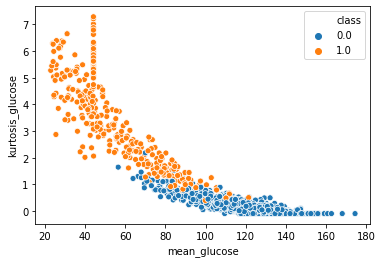

In [36]:
sns.scatterplot(rdata.mean_glucose, rdata.kurtosis_glucose, hue=rdata['class'])

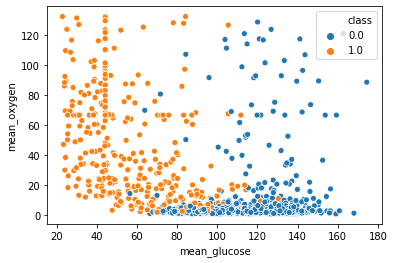

In [37]:
sns.scatterplot(rdata.mean_glucose, rdata.mean_oxygen, hue=rdata['class'])

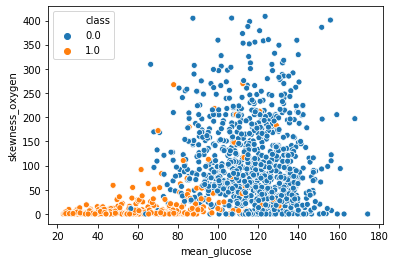

In [38]:
sns.scatterplot(rdata.mean_glucose, rdata.skewness_oxygen, hue=rdata['class'])

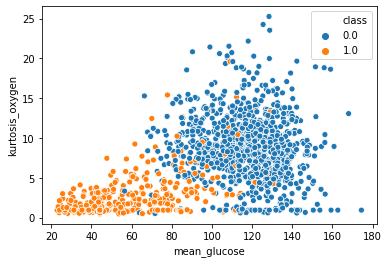

In [39]:
sns.scatterplot(rdata.mean_glucose, rdata.kurtosis_oxygen, hue=rdata['class'])

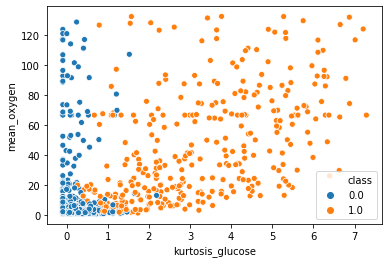

In [40]:
sns.scatterplot(rdata.kurtosis_glucose, rdata.mean_oxygen, hue=rdata['class'])

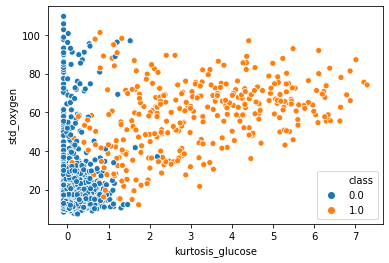

In [41]:
sns.scatterplot(rdata.kurtosis_glucose, rdata.std_oxygen, hue=rdata['class'])

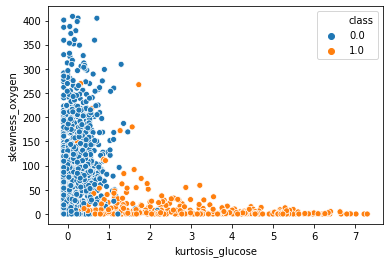

In [42]:
sns.scatterplot(rdata.kurtosis_glucose, rdata.skewness_oxygen, hue=rdata['class'])

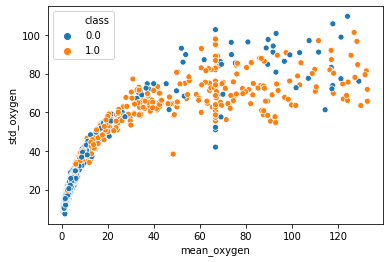

In [43]:
sns.scatterplot(rdata.mean_oxygen, rdata.std_oxygen, hue=rdata['class'])

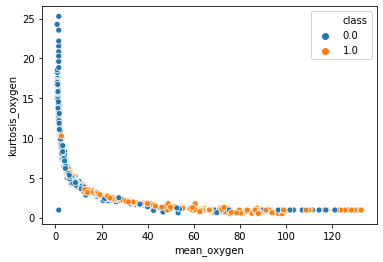

In [44]:
sns.scatterplot(rdata.mean_oxygen, rdata.kurtosis_oxygen, hue=rdata['class'])

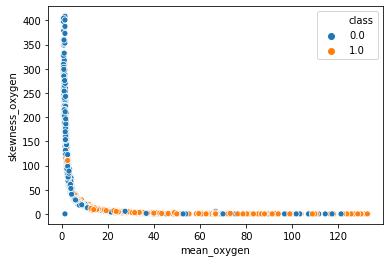

In [45]:
sns.scatterplot(rdata.mean_oxygen, rdata.skewness_oxygen, hue=rdata['class'])

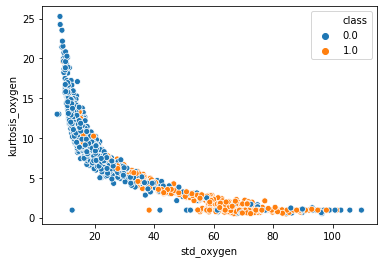

In [46]:
sns.scatterplot(rdata.std_oxygen, rdata.kurtosis_oxygen, hue=rdata['class'])

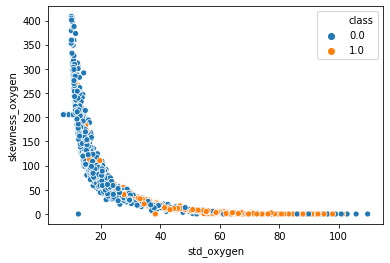

In [47]:
sns.scatterplot(rdata.std_oxygen, rdata.skewness_oxygen, hue=rdata['class'])

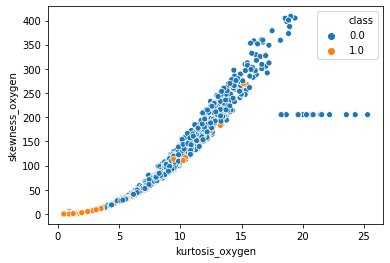

In [48]:
sns.scatterplot(rdata.kurtosis_oxygen, rdata.skewness_oxygen, hue=rdata['class'])

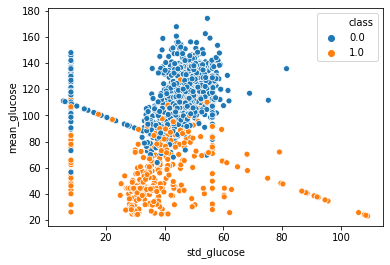

In [49]:
sns.scatterplot(rdata.std_glucose, rdata.mean_glucose, hue=rdata['class'])

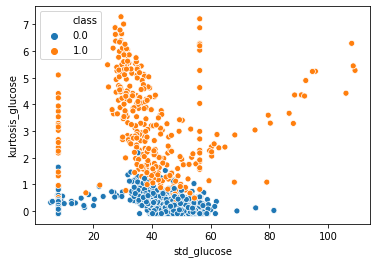

In [50]:
sns.scatterplot(rdata.std_glucose, rdata.kurtosis_glucose, hue=rdata['class'])

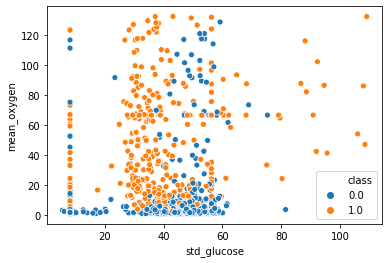

In [51]:
sns.scatterplot(rdata.std_glucose, rdata.mean_oxygen, hue=rdata['class'])

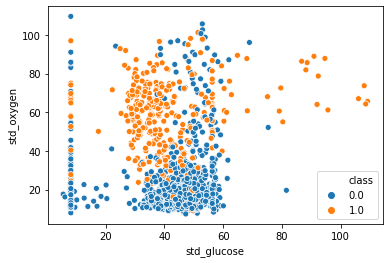

In [52]:
sns.scatterplot(rdata.std_glucose, rdata.std_oxygen, hue=rdata['class'])

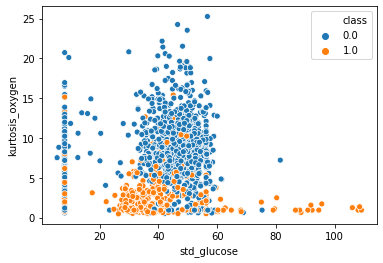

In [53]:
sns.scatterplot(rdata.std_glucose, rdata.kurtosis_oxygen, hue=rdata['class'])

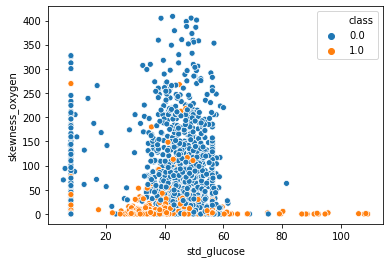

In [54]:
sns.scatterplot(rdata.std_glucose, rdata.skewness_oxygen, hue=rdata['class'])

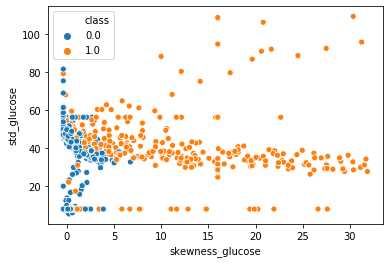

In [55]:
sns.scatterplot(rdata.skewness_glucose, rdata.std_glucose, hue=rdata['class'])

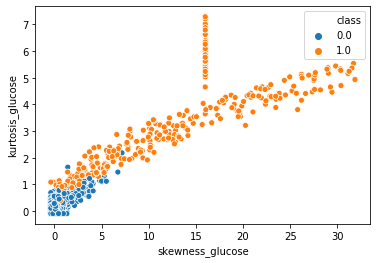

In [56]:
sns.scatterplot(rdata.skewness_glucose, rdata.kurtosis_glucose, hue=rdata['class'])

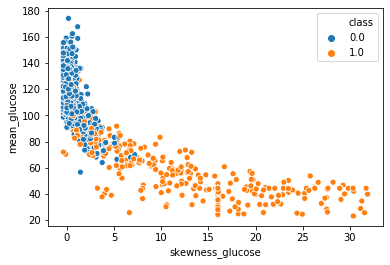

In [57]:
sns.scatterplot(rdata.skewness_glucose, rdata.mean_glucose, hue=rdata['class'])

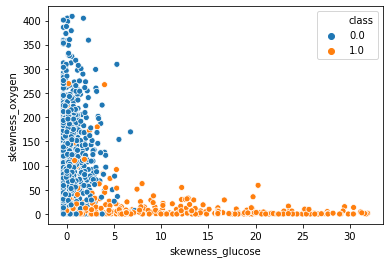

In [58]:
sns.scatterplot(rdata.skewness_glucose, rdata.skewness_oxygen, hue=rdata['class'])

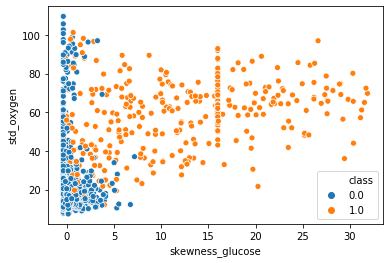

In [59]:
sns.scatterplot(rdata.skewness_glucose, rdata.std_oxygen, hue=rdata['class'])

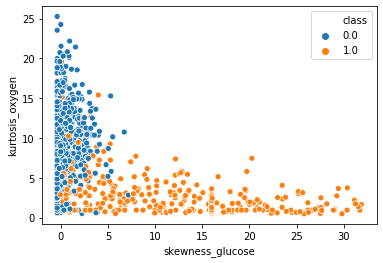

In [60]:
sns.scatterplot(rdata.skewness_glucose, rdata.kurtosis_oxygen, hue=rdata['class'])

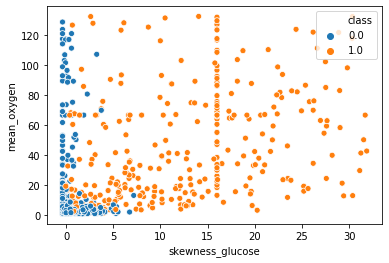

In [61]:
sns.scatterplot(rdata.skewness_glucose, rdata.mean_oxygen, hue=rdata['class'])

In [62]:
def getValue(line):
    if line[1]['mean_glucose'] < 55:
        return 1
    elif line[1]['kurtosis_glucose'] > 2.2:
        return 1            
    else:
        if line[1]['mean_glucose'] < 85:
            if line[1]['kurtosis_oxygen'] < 4.7:
                return 1
            elif line[1]['skewness_oxygen'] < 30:
                return 1
            elif line[1]['mean_oxygen'] > 15:
                return 1
            elif line[1]['skewness_glucose'] > 7.2:
                return 1
            else:
                return 0 
        elif line[1]['age'] > 76:
            return 1
        else:
            return 0

In [63]:
positive = 0
negative = 0
correctCounter = 0
falsePositive = 0
falseNegative = 0
for line in rdata.iterrows():
    if line[1][20] == 1:
        positive += 1
    else:
        negative += 1
    if getValue(line) == line[1][20]:
        correctCounter += 1
    else:
        if getValue(line) == 1:
            falsePositive += 1
        else:
            falseNegative += 1
        if line[1][15] < 85:
            print(getValue(line), line[1][20])
            print(line[1])
            print("=============") 
                   
        
        
    
print("Correct: ", (correctCounter / (correctCounter + falsePositive + falseNegative)) * 100, "%")
print("falsePositive: ",falsePositive)
print("falseNegative: ",falseNegative)
print("positive: ", positive)
print("negative: ", negative)

1 0.0
id_x                                                            182
name                                                Michael Fairley
address_x           2304 Ho Hollow Suite 979\r\nCarlshire, DE 63767
age                                                              37
sex                                                            Male
date_of_birth                                            1982-06-23
id_y                                                            806
address_y           2304 Ho Hollow Suite 979\r\nCarlshire, DE 63767
race                                                          White
marital-status                                   Married-civ-spouse
occupation                                           Prof-specialty
pregnant                                                          0
education-num                                                    13
relationship                                                Husband
skewness_glucose                          

0 1.0
id_x                                        1294
name                                Thomas Brown
address_x           USNV Brennan\r\nFPO AA 97325
age                                           54
sex                                         Male
date_of_birth                         1964-12-18
id_y                                        1053
address_y           USNV Brennan\r\nFPO AA 97325
race                                       White
marital-status                     Never-married
occupation                        Prof-specialty
pregnant                                       0
education-num                                 10
relationship                           Own-child
skewness_glucose                        0.807797
mean_glucose                             82.6172
capital-gain                                   0
kurtosis_glucose                        0.919883
education                           Some-college
fnlwgt                                    137578
class         

In [64]:
rows = []
for row in data.iterrows():
    rows.append(row[1])

In [65]:
def class_counts(rows):
    counts = {} 
    for row in rows:
        label = row['class']
        if label not in counts:
            counts[label] = 0
        counts[label] += 1
    return counts

In [66]:
def is_numeric(value):
    return isinstance(value, int) or isinstance(value, float)

In [67]:
class Question:
    def __init__(self, column, value):
        self.column = column
        self.value = value

    def match(self, example):
        val = example[self.column]
        if is_numeric(val):
            return val >= self.value
        else:
            return val == self.value
               

In [68]:
def partition(rows, question):
    true_rows, false_rows = [], []
    for row in rows:
        if question.match(row):
            true_rows.append(row)
        else:
            false_rows.append(row)
    return true_rows, false_rows

In [69]:
true_rows, false_rows = partition(rows, Question('class', 1))

In [70]:
def gini(rows):
    counts = class_counts(rows)
    impurity = 1
    for lbl in counts:
        prob_of_lbl = counts[lbl] / float(len(rows))
        impurity -= prob_of_lbl**2
    return impurity

In [71]:
def info_gain(left, right, current_uncertainty):
    p = float(len(left)) / (len(left) + len(right))
    return current_uncertainty - p * gini(left) - (1 - p) * gini(right)

In [72]:
current_uncertainty = gini(rows)
current_uncertainty

0.3802202012103445

In [73]:
true_rows, false_rows = partition(rows, Question('class', 1))
info_gain(true_rows, false_rows, current_uncertainty)

0.3802202012103445

In [74]:
def find_best_split(rows):
    
    best_gain = 0 
    best_question = None
    current_uncertainty = gini(rows)
    n_features = len(rdata.columns) - 1 

    for col in range(n_features): 

        values = set([row[col] for row in rows])

        for val in values:

            question = Question(col, val)

            true_rows, false_rows = partition(rows, question)

            if len(true_rows) == 0 or len(false_rows) == 0:
                continue

            gain = info_gain(true_rows, false_rows, current_uncertainty)

            if gain >= best_gain:
                best_gain, best_question = gain, question

    return best_gain, best_question

In [75]:
class Leaf:
    def __init__(self, rows):
        self.predictions = class_counts(rows)

In [76]:
class Decision_Node:
    def __init__(self,
                 question,
                 true_branch,
                 false_branch):
        self.question = question
        self.true_branch = true_branch
        self.false_branch = false_branch

In [77]:
def build_tree(rows):
    gain, question = find_best_split(rows)

    if gain < 0.2:
        return Leaf(rows)

    true_rows, false_rows = partition(rows, question)

    true_branch = build_tree(true_rows)

    false_branch = build_tree(false_rows)

    return Decision_Node(question, true_branch, false_branch)

In [78]:
def print_tree(node, spacing=""):
    if isinstance(node, Leaf):
        print (spacing + "Predict", node.predictions)
        return

    print (spacing + str(node.question))

    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")

In [81]:
my_tree = build_tree(rows)

In [82]:
print_tree(my_tree)

--> True:
  Predict {1.0: 1004}
--> False:
  Predict {0.0: 2929}


In [83]:
def classify(row, node):
    # Base case: we've reached a leaf
    if isinstance(node, Leaf):
        return node.predictions
    if node.question.match(row):
        return classify(row, node.true_branch)
    else:
        return classify(row, node.false_branch)

In [84]:
def print_leaf(counts):
    total = sum(counts.values()) * 1.0
    probs = {}
    for lbl in counts.keys():
        probs[lbl] = str(int(counts[lbl] / total * 100)) + "%"
    return probs

In [85]:
validRows = []
for row in rdata.iterrows():
    validRows.append(row[1])

In [86]:
for row in validRows:
    print ("Actual: %s. Predicted: %s" %
           (row['class'], print_leaf(classify(row, my_tree))))

Actual: 0.0. Predicted: {0.0: '100%'}
Actual: 0.0. Predicted: {0.0: '100%'}
Actual: 0.0. Predicted: {0.0: '100%'}
Actual: 0.0. Predicted: {0.0: '100%'}
Actual: 0.0. Predicted: {0.0: '100%'}
Actual: 0.0. Predicted: {0.0: '100%'}
Actual: 0.0. Predicted: {0.0: '100%'}
Actual: 1.0. Predicted: {1.0: '100%'}
Actual: 0.0. Predicted: {0.0: '100%'}
Actual: 0.0. Predicted: {0.0: '100%'}
Actual: 0.0. Predicted: {0.0: '100%'}
Actual: 0.0. Predicted: {0.0: '100%'}
Actual: 0.0. Predicted: {0.0: '100%'}
Actual: 0.0. Predicted: {0.0: '100%'}
Actual: 0.0. Predicted: {0.0: '100%'}
Actual: 0.0. Predicted: {0.0: '100%'}
Actual: 0.0. Predicted: {0.0: '100%'}
Actual: 0.0. Predicted: {0.0: '100%'}
Actual: 0.0. Predicted: {0.0: '100%'}
Actual: 0.0. Predicted: {0.0: '100%'}
Actual: 0.0. Predicted: {0.0: '100%'}
Actual: 0.0. Predicted: {0.0: '100%'}
Actual: 0.0. Predicted: {0.0: '100%'}
Actual: 0.0. Predicted: {0.0: '100%'}
Actual: 0.0. Predicted: {0.0: '100%'}
Actual: 0.0. Predicted: {0.0: '100%'}
Actual: 0.0.